In [1]:
import sys
%load_ext autoreload
%autoreload 2

#### summed_like_tool can be obtained from github: https://github.com/mireianievas/summed_like_tool
#### shame on me for the complete lack of documentation. 

sys.path.append("/home/mnievas/Software/summed_like_tool/")
#from summed_like_tool import fermi,lst,utils,fitmaker
import astropy.units as u
import regions
import matplotlib.pyplot as plt
from summed_like_tool.fermi import analysis as fermianalysis
from summed_like_tool.fitmaker import spectrum as spectrum
from gammapy.maps import WcsGeom
from gammapy.modeling.models import (
    SkyModel,
    EBLAbsorptionNormSpectralModel,
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
)

In [2]:
%env GAMMAPY_DATA=/home/mnievas/Software/cta/gammapy/gammapy-datasets/

env: GAMMAPY_DATA=/home/mnievas/Software/cta/gammapy/gammapy-datasets/


In [3]:
redshift = 0.00428

dominguez = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)
lat_path = "/home/mnievas/LAT/M87_2020-2021/"
lat_aux  = "/home/mnievas/LAT/enrico/Data/diffuse/"
srcmodel = 'PowerLaw'
targetname = "M87"

In [4]:
FermiFrontBack = fermianalysis.FermiAnalysis(lat_path,lat_aux,srcmodel)
FermiFrontBack.prepare_files('FRONT')

In [5]:
FermiFrontBack.print_selected_files()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 59183.999954 from DATE-OBS.
Set MJD-END to 59393.996170 from DATE-END'. [astropy.wcs.wcs]


Peek on original edisp kernel


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


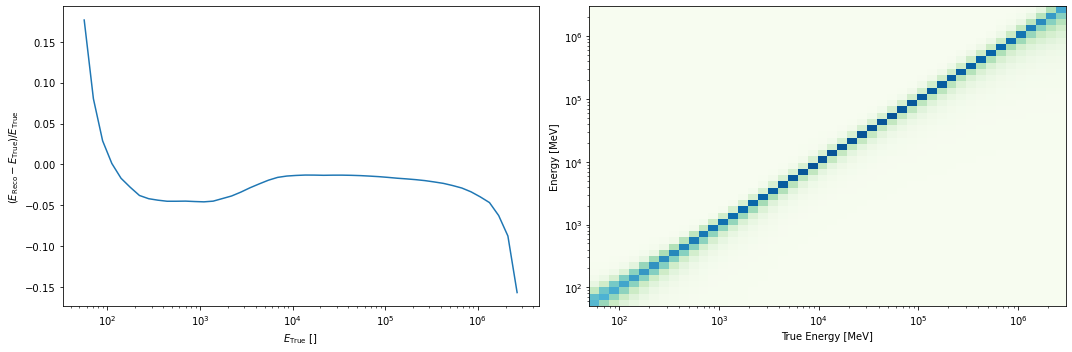

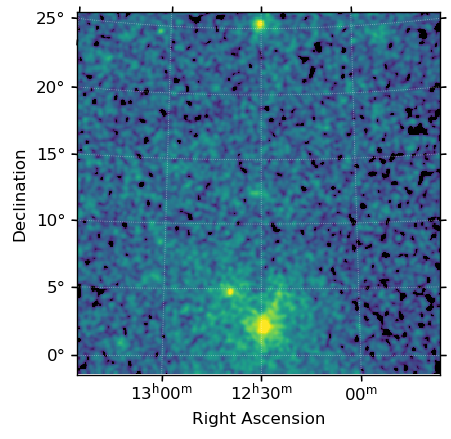

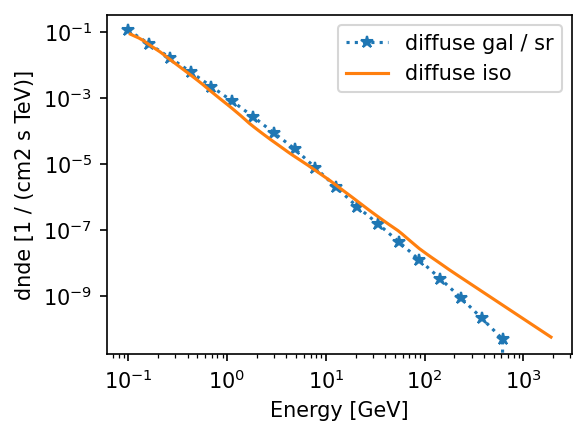

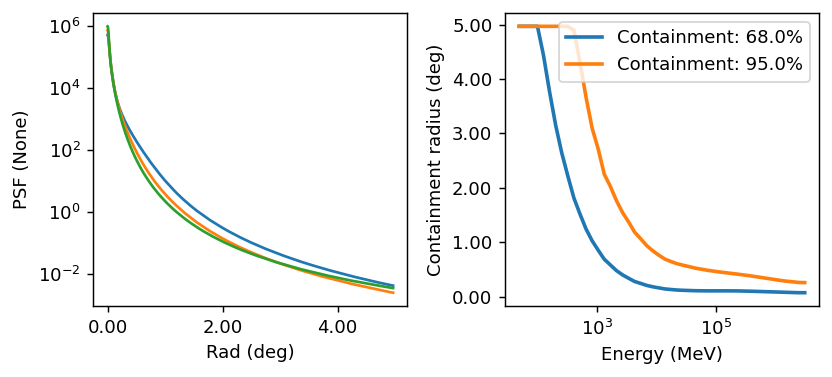

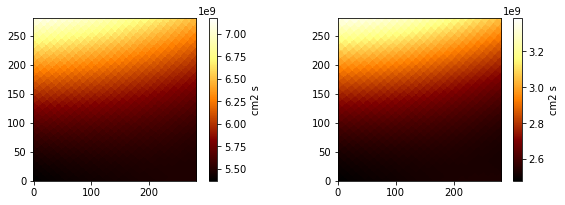

In [6]:
FermiFrontBack.gen_analysis(targetname,redshift=redshift,ebl_model='dominguez')

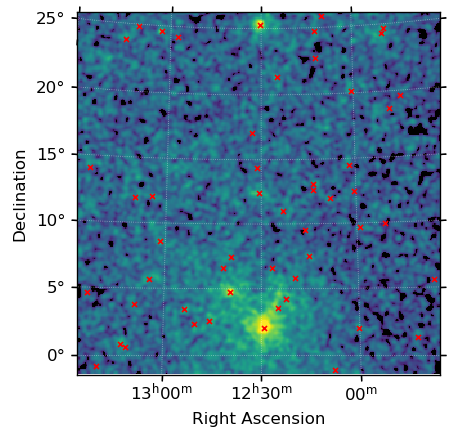

In [7]:
FermiFrontBack.plot_counts_map()
for s in FermiFrontBack.SkyModel.list_sources:
    spatial = s.spatial_model
    if (spatial.tag[0]=='PointSpatialModel'):
        for c in spatial.parameters:
            if c.name == 'lon_0':
                lon = c.value
            if c.name == 'lat_0':
                lat = c.value
        #print(lon,lat,c)
        plt.gca().plot_coord(spatial.position,color='red',marker='x',ms=3)
        #break


In [8]:
# Filter out data far away from the source position in the minimization
exclusion_region = regions.CircleAnnulusSkyRegion(FermiFrontBack.dataset.mask_image.geom.center_skydir,
                                          10*u.deg,30*u.deg)

FermiFrontBack.add_exclusion_region(exclusion_region)
FermiFrontBack.create_exclusion_mask()

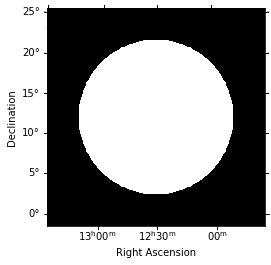

In [9]:
FermiFrontBack.exclusion_mask.plot_interactive()

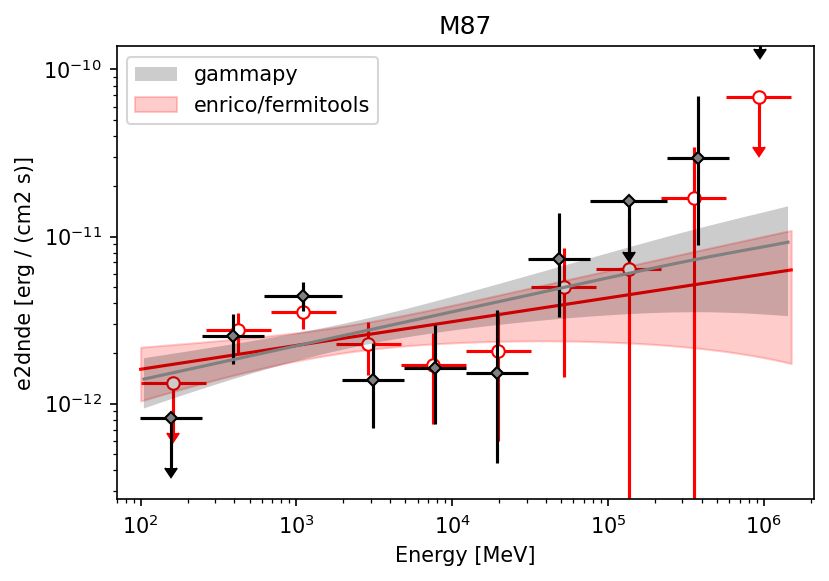

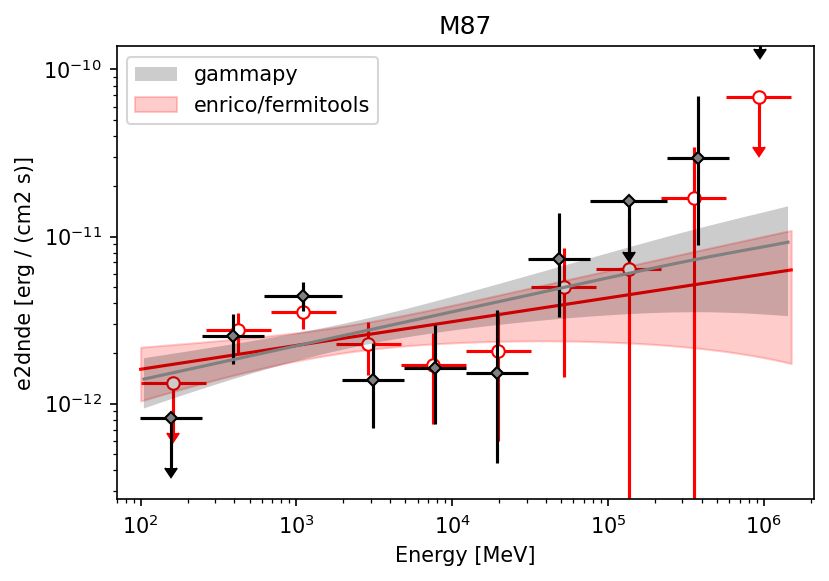

In [10]:
FSpectrum = spectrum.SpectralAnalysis([FermiFrontBack])
FSpectrum.set_energy_mask(FSpectrum.datasets[0],emin=100*u.MeV,emax=1000*u.GeV)
FSpectrum.global_fit()
FSpectrum.set_target_source(targetname)
FSpectrum.read_enrico_spectrum()
FSpectrum.get_spectral_points()
FSpectrum.plot_spectrum()
FSpectrum.plot_spectrum_enrico()

(<WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>,
 <AxesSubplot:xlabel='Energy [MeV]', ylabel='Residuals (data - model)'>)

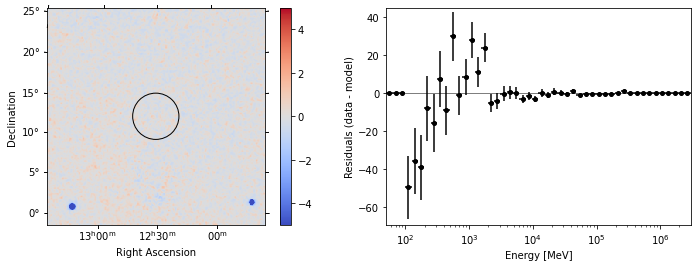

In [11]:
srcpos = FermiFrontBack.SkyModel.list_sources[-1].spatial_model.position
FermiFrontBack.dataset.plot_residuals(kwargs_spectral={'region':regions.CircleSkyRegion(srcpos,radius=3*u.deg)})

### MAGIC 

In [12]:
from summed_like_tool.iact import analysis as iactanalysis
import os
import glob
import numpy as np
from gammapy.data import DataStore
from pathlib import Path
import astropy.io.fits as pyfits

In [13]:
#!rm -rf /home/mnievas/DL3/M87/MAGIC/all/20*DL3*.fits
#!rm -rf /home/mnievas/DL3/M87/MAGIC/fold/20*DL3*.fits

In [14]:
#!ls /mnt/sda1/MAGIC/M87/M87_ST0316/M87/DL3/*/20*DL3*.fits | wc -l

In [15]:
#!cp -a /mnt/sda1/MAGIC/M87/M87_ST0316/M87/DL3/*/20*DL3*.fits /home/mnievas/DL3/M87/MAGIC/all/
#!cp -a /home/mnievas/DL3/M87/MAGIC/{Dark,Light,Moderate,Bright,VeryBright}/*DL3*.fits /home/mnievas/DL3/M87/MAGIC/all/

In [16]:
#!ls /home/mnievas/DL3/M87/MAGIC/all/2*.fits | wc -l

In [17]:
#!rsync -av -L /mnt/sda1/MAGIC/M87/M87_ST0316/M87/Flute/*{fold,foam,combine,Fold,Foam,Combine}* /home/mnievas/DL3/M87/MAGIC/fold/
#!micsync mic:~/CurrentSource/M87/Flute/*{fold,foam,combine,Fold,Foam,Combine}* /home/mnievas/DL3/M87/MAGIC/fold/

In [18]:
magicpath = "/home/mnievas/DL3/M87/MAGIC/all/"
paths = glob.glob(f"{magicpath}/2*DL3*.fits")

In [19]:
len(paths)

137

In [20]:
pyfits.open(paths[0])[3].header

/tmp/ipykernel_1485221/2331126356.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='/home/mnievas/DL3/M87/MAGIC/all/20210322_05095578_DL3_M87-W0.40+000.fits'>
  pyfits.open(paths[0])[3].header


XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  296 / width of table in bytes                        
NAXIS2  =                    1 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    5 / number of fields in each row                   
TTYPE1  = 'ENERG_LO'           / label for field   1                            
TFORM1  = '24E     '           / data format of field: 4-byte REAL              
TUNIT1  = 'TeV     '           / physical unit of field                         
TTYPE2  = 'ENERG_HI'           / label for field   2                            
TFORM2  = '24E     '        

In [21]:
magicpath = "/home/mnievas/DL3/M87/MAGIC/all/"
#paths = glob.glob(f"{magicpath}/20*DL3*.fits")
#data_store = DataStore.from_events_files(paths)
#observations = data_store.get_observations(required_irf=["psf","aeff", "edisp","rad_max"])
#data_store.hdu_table.write("hdu-index.fits.gz",overwrite=True) 
#data_store.obs_table.write("obs-index.fits.gz",overwrite=True) 

In [22]:
srcmodel = "PowerLaw"
MAGIC = iactanalysis.Analysis1D(magicpath,srcmodel)
MAGIC.create_datastore(overwrite=True)
#MAGIC.get_targetname()
MAGIC.set_targetname("M87")
MAGIC.get_observations()
MAGIC.set_energy_axes()
MAGIC.set_src_pos()
MAGIC.set_on_region()
MAGIC.run_region_finder(1)
MAGIC.create_safe_mask_min_aeff(
    aeff_percent=5,
    bias_percent=5
)
MAGIC.add_exclusion_region()
MAGIC.create_exclusion_mask()
MAGIC.create_datasets()
spectral_model_lp = PowerLawSpectralModel(
    amplitude=1e-10 * u.Unit("cm-2 s-1 TeV-1"),
    index=2.2,
    #beta=0.02,
    reference=0.5*u.TeV,
)
magic_model = SkyModel(spectral_model=spectral_model_lp, 
                     name=MAGIC.targetname)

from gammapy.datasets import (
    Datasets,
)

MAGIC.dataset = Datasets(MAGIC.datasets).stack_reduce(name='MAGIC')

MAGIC.dataset.models = [magic_model]
#MAGIC.dataset.models = [FermiFrontBack.dataset.models[-1]]


obs/hdu index files not found, creating them from /home/mnievas/DL3/M87/MAGIC/all/
No default upper safe energy threshold defined for obs 5095578
No default upper safe energy threshold defined for obs 5095526
No default upper safe energy threshold defined for obs 5097215
No default upper safe energy threshold defined for obs 5096306
No default upper safe energy threshold defined for obs 5096639
No default upper safe energy threshold defined for obs 5096391
No default upper safe energy threshold defined for obs 5094746
No default upper safe energy threshold defined for obs 5093514
No default upper safe energy threshold defined for obs 5094663
No default upper safe energy threshold defined for obs 5094661
No default upper safe energy threshold defined for obs 5095953
No default upper safe energy threshold defined for obs 5093534
No default upper safe energy threshold defined for obs 5096310
No default upper safe energy threshold defined for obs 5096078
No default upper safe energy thresh

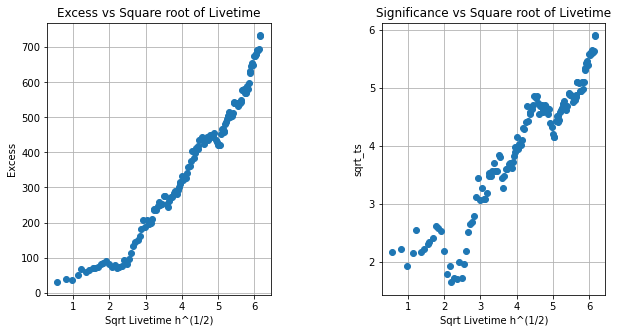

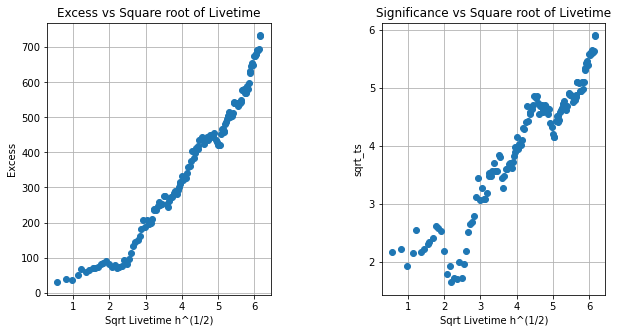

In [23]:
MAGIC.plot_excess_ts_livetime()

In [24]:
myobs = MAGIC.observations_total[0]

<>:70: DeprecationWarning: invalid escape sequence \m
<>:71: DeprecationWarning: invalid escape sequence \s
<>:70: DeprecationWarning: invalid escape sequence \m
<>:71: DeprecationWarning: invalid escape sequence \s
/tmp/ipykernel_1485221/2936849365.py:70: DeprecationWarning: invalid escape sequence \m
  plt.ylabel('$\mathrm{N_{events}}$')
/tmp/ipykernel_1485221/2936849365.py:71: DeprecationWarning: invalid escape sequence \s
  plt.text(0.4,0.9,f'Significance = {np.sqrt(TStot):.1f} $\sigma$',transform=plt.gca().transAxes )


Text(0.4, 0.9, 'Significance = 5.1 $\\sigma$')

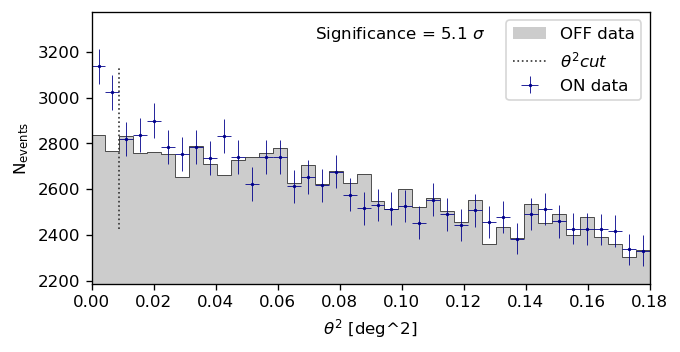

In [25]:
from gammapy.makers.utils import make_theta_squared_table
from gammapy.visualization import plot_theta_squared_table
from gammapy.maps import MapAxis

theta2cut_f = 0.009
thetacut  = np.sqrt(theta2cut_f)

theta2_axis = MapAxis.from_bounds(0, theta2cut_f*20, nbin=40, interp="lin", unit="deg2")

theta2_table = make_theta_squared_table(
    observations=MAGIC.observations_total,
    position=MAGIC.src_pos,
    theta_squared_axis=theta2_axis,
)
#plt.figure(dpi=120)
#plot_theta_squared_table(theta2_table)

plt.figure(figsize=(6,3),dpi=120)
plt.stairs(
    edges=np.append(theta2_table['theta2_min'],
                    theta2_table['theta2_max'][-1]),
    values=theta2_table['counts_off'],
    fill=True,
    color='0.2',
    facecolor='0.8',
    label='OFF data'
)

plt.stairs(
    edges=np.append(theta2_table['theta2_min'],
                    theta2_table['theta2_max'][-1]),
    values=theta2_table['counts_off'],
    fill=False,
    color='0.2',
    lw=0.5,
)

plt.errorbar(
    x = 0.5*(theta2_table['theta2_min']+theta2_table['theta2_max']),
    xerr = 0.5*(theta2_table['theta2_max']-theta2_table['theta2_min']),
    y = theta2_table['counts_off'] + theta2_table['excess'],
    yerr = [-theta2_table['excess_errn'],theta2_table['excess_errp'],],
    ls='None',
    color='darkblue',
    label='ON data',
    lw=0.5,
    marker='o',
    ms=1,
)


theta2cut = theta2_table['theta2_max']<=theta2cut_f

min_off_counts = np.min(theta2_table['counts_off'])
min_on_counts = np.min(theta2_table['counts']+theta2_table['excess_errn'])


TStot = np.sum(theta2_table['sqrt_ts'][theta2cut]*\
               np.abs(theta2_table['sqrt_ts'][theta2cut]))

plt.axvline(theta2_table['theta2_max'][theta2cut][-1],
            ls='dotted',
            ymin=0.2,ymax=0.8,
            color='0.2',label='$\\theta^2 cut$',lw=1)

plt.ylim(np.min([min_off_counts*0.95,min_on_counts*0.98]),)
plt.legend()
plt.xlabel('$\\theta^2$ [deg^2]')
plt.xlim(0,theta2cut_f*20)
plt.ylabel('$\mathrm{N_{events}}$')
plt.text(0.4,0.9,f'Significance = {np.sqrt(TStot):.1f} $\sigma$',transform=plt.gca().transAxes )

In [26]:
!ls /home/mnievas/DL3/M87/MAGIC/fold/

combine_lc_output_CurrentSource_M87_Flute.png	      Fold_ON.pdf
combine_lc_output_CurrentSource_M87_Flute.png_c2.png  Log_foam.log
combine_lc_output_.png				      Log_fold.log
combine_lc_output_.png_c2.png			      Output_fold.root
combine_lc_output.root				      Status_foam.root
foam.root					      Status_fold.root


In [27]:
import uproot
foam = uproot.open("/home/mnievas/DL3/M87/MAGIC/fold/foam.root")

In [28]:
sss = foam['total_non']

In [29]:
sss.to_numpy()

(array([3.000e+00, 1.400e+01, 2.800e+01, 1.150e+02, 8.570e+02, 5.001e+03,
        8.296e+03, 6.059e+03, 2.265e+03, 1.505e+03, 6.300e+02, 3.200e+02,
        1.360e+02, 9.300e+01, 5.500e+01, 2.800e+01, 1.300e+01, 6.000e+00,
        8.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([5.13729744e+00, 7.54052142e+00, 1.10679718e+01, 1.62455609e+01,
        2.38452224e+01, 3.50000000e+01, 5.13729744e+01, 7.54052142e+01,
        1.10679718e+02, 1.62455609e+02, 2.38452224e+02, 3.50000000e+02,
        5.13729744e+02, 7.54052142e+02, 1.10679718e+03, 1.62455609e+03,
        2.38452224e+03, 3.50000000e+03, 5.13729744e+03, 7.54052142e+03,
        1.10679718e+04, 1.62455609e+04, 2.38452224e+04, 3.50000000e+04,
        5.13729744e+04]))

No covariance estimate - not supported by this backend.


  type      name     value         unit      ...    max    frozen is_norm link
-------- --------- ---------- -------------- ... --------- ------ ------- ----
spectral     index 2.3000e+00                ... 3.500e+00  False   False     
spectral amplitude 2.0000e-12 cm-2 s-1 TeV-1 ... 5.000e-11  False    True     
spectral reference 5.0000e-01            TeV ... 5.000e-01   True   False     


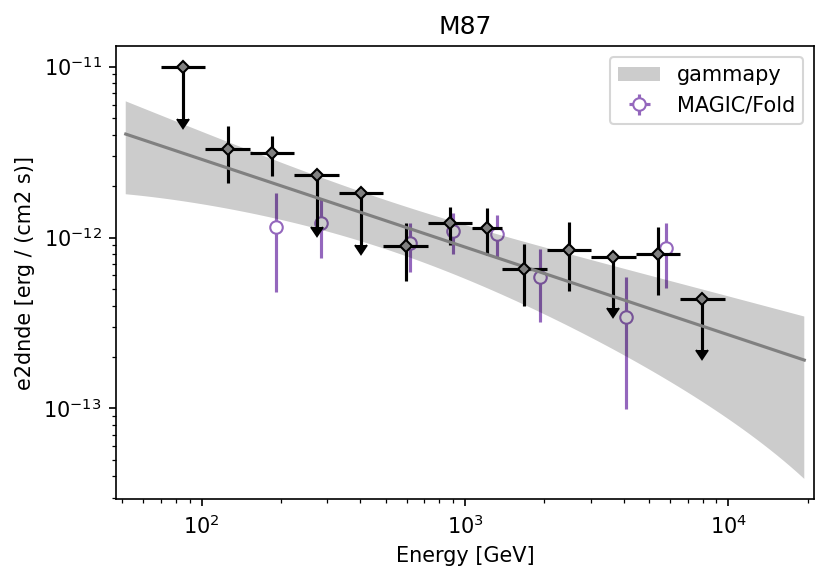

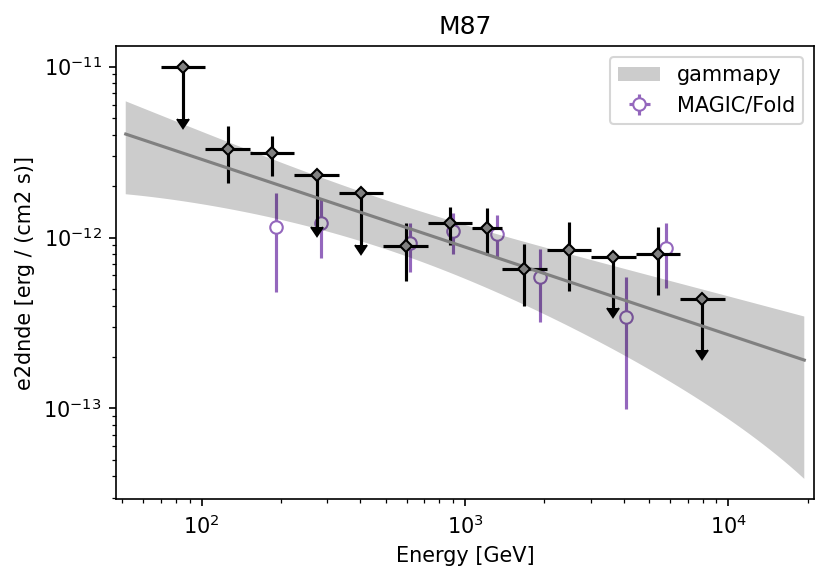

In [30]:
scipy_opts = {
    "method": "L-BFGS-B",
    "options": {"ftol": 1e-4, "gtol": 1e-05},
    "backend": "scipy",
}

MSpectrum = spectrum.SpectralAnalysis([MAGIC],backend='scipy',optimize_opts = scipy_opts,store_trace=True)
mod = MSpectrum.datasets[0].models
mod.parameters.value = [2.3, 2e-12, 0.5]
mod.parameters.max   = [3.5, 5e-11, 0.5]
mod.parameters.min   = [1.5, 1e-13, 0.5]
mod.parameters[0].error = 0.2
mod.parameters[1].error = 1e-12
print(mod.parameters.to_table())
#MSpectrum.global_fit()
MSpectrum.set_target_source(targetname)
MSpectrum.set_energy_mask(MSpectrum.datasets[0],emin=80*u.GeV,emax=10*u.TeV)
MSpectrum.global_fit()

MSpectrum.target_model = MAGIC.dataset.models[0]
MSpectrum.get_spectral_points(np.logspace(np.log10(50),np.log10(20000),17)*u.GeV)
MSpectrum.plot_spectrum()
MSpectrum.plot_spectrum_fold(f"{magicpath.replace('all','fold')}/Output_fold.root")

In [31]:
MSpectrum.fit.minuit

In [32]:
print(MAGIC.dataset.models[-1])

SkyModel

  Name                      : M87
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.513   +/-    0.20             
    amplitude                     :   3.13e-12   +/- 1.0e-12 1 / (cm2 s TeV)
    reference             (frozen):      0.500       TeV         




In [33]:
from gammapy.estimators import LightCurveEstimator
import astropy.time as atime

lc_maker = LightCurveEstimator(
    energy_edges=[0.35, 20] * u.TeV, source="M87-MAGIC", reoptimize=False,
)


magic_lc = lc_maker.run(MAGIC.dataset)
magic_lc_table = magic_lc.to_table(sed_type="flux", 
                                   format="lightcurve")

print(magic_lc_table)
#magic_lc.plot(color="tab:orange")
#ax = magic_lc.plot_ts_profiles()


ValueError: 'M87-MAGIC' is not in list

In [34]:
FMSpectrum = spectrum.SpectralAnalysis([FermiFrontBack,MAGIC])
#FMSpectrum.global_fit()
#FMSpectrum.set_target_source(targetname)
#FMSpectrum.set_energy_mask(FMSpectrum.datasets[0],emin=80*u.GeV,emax=10*u.TeV)
#FMSpectrum.target_model = MAGIC.dataset.models[0]
#FMSpectrum.get_spectral_points(np.logspace(1.8,4,13)*u.GeV)
#FMSpectrum.plot_spectrum()
#FMSpectrum.plot_spectrum_fold(f"{magicpath.replace('all','fold')}/Output_fold.root")

In [35]:
spectral_model_lp = LogParabolaSpectralModel(
    amplitude=1e-9 * u.Unit("cm-2 s-1 TeV-1"),
    index=1.9,
    beta=0.02,
    reference=10*u.GeV,
)

In [36]:
from gammapy.modeling.models.core import DatasetModels
import astropy.table as tab

models = DatasetModels(FermiFrontBack.dataset.models)
models[-1].spectral_model = spectral_model_lp

for model in models:
    model.datasets_names = ['Fermi-LAT_FRONT']
    
models[-1].datasets_names = ['Fermi-LAT_FRONT','MAGIC']


#model_1d = SkyModel(
#    spectral_model=models[-1].spectral_model,
#    name="M87-MAGIC",
#    datasets_names=["MAGIC"],
#)
#models = models + model_1d


In [37]:
FMSpectrum.datasets.models = models

In [38]:
print(FMSpectrum.datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT_FRONT
  Instrument : 
  Models     : ['4FGL J1137.3+0535', '4FGL J1142.8+0120', '4FGL J1144.9+1937', '4FGL J1148.6+1841', '4FGL J1149.4+2441', '4FGL J1150.4+2418', '4FGL J1151.3+0957', '4FGL J1159.0+0939', '4FGL J1200.2+0201', '4FGL J1200.6+1229', '4FGL J1200.7+2008', '4FGL J1201.7+1429', '4FGL J1207.7-0106', '4FGL J1208.2+1158', '4FGL J1209.7+2548', '4FGL J1212.0+2242', '4FGL J1212.2+2442', '4FGL J1213.6+1236', '4FGL J1213.6+1306', '4FGL J1215.1+0731', '4FGL J1216.1+0930', '4FGL J1219.6+0550', '4FGL J1222.5+0414', '4FGL J1223.0+1100', '4FGL J1224.9+2122', '4FGL J1225.0+0330', '4FGL J1226.7+0637', '4FGL J1229.0+0202', '4FGL J1230.2+2517', '4FGL J1231.5+1421', '4FGL J1233.1+1703', '4FGL J1233.7-0144', '4FGL J1239.4+0728', '4FGL J1239.5+0443', '4FGL J1241.9+0636', '4FGL J1245.8+0232', '4FGL J1250.6+0217', '4FGL J1253.8+0327', '4FGL J1257.6+2413', '4FGL J1301.6+0834', '4FGL J1303.0+2434', '4FGL J1304.4+1203

In [39]:
print(models[-1])

SkyModel

  Name                      : M87
  Datasets names            : ['Fermi-LAT_FRONT', 'MAGIC']
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-09   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):     10.000       GeV         
    alpha                         :      2.000   +/-    0.00             
    beta                          :      0.020   +/-    0.00             
    lon_0                 (frozen):    187.706       deg         
    lat_0                 (frozen):     12.391       deg         




In [40]:
FMSpectrum.set_energy_mask(FMSpectrum.datasets[0],emin=100*u.MeV,emax=30*u.TeV)
FMSpectrum.set_energy_mask(FMSpectrum.datasets[1],emin=100*u.MeV,emax=30*u.TeV)
FMSpectrum.global_fit()

In [41]:
FMSpectrum.ebin_edges = [0.1*u.GeV,30*u.TeV]
FMSpectrum.set_target_source(FMSpectrum.datasets.models[-1].name)

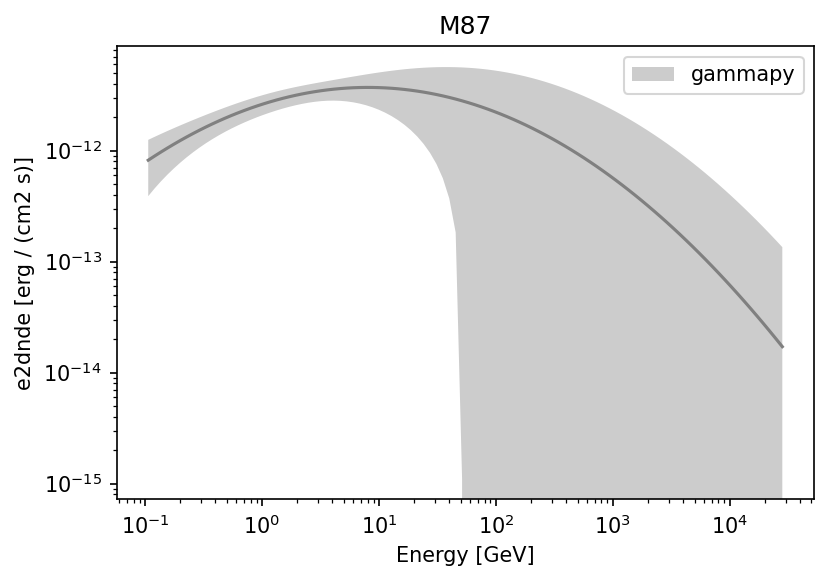

In [42]:
FMSpectrum.plot_spectrum()

In [ ]:
FMSpectrum.datasets["MAGIC"].npred().data.flatten()

(1e-15, 4e-11)

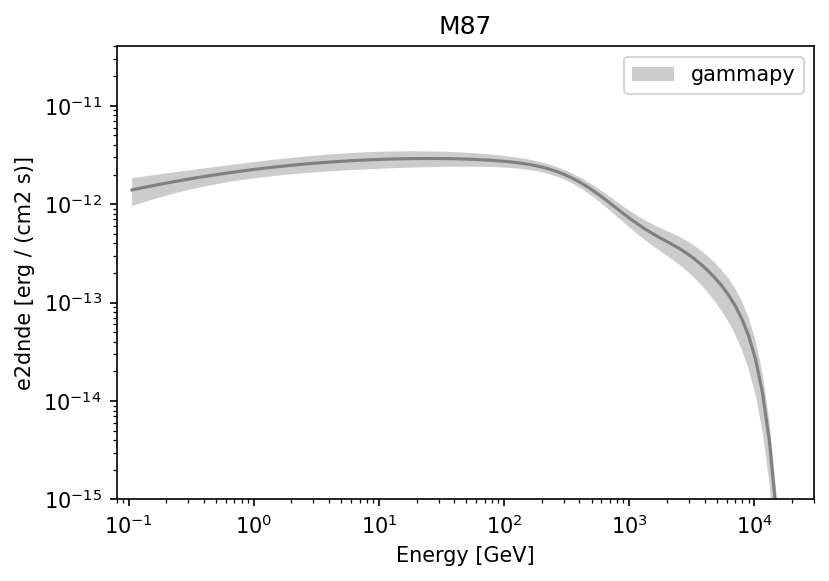

In [44]:
FMSpectrum2 = spectrum.SpectralAnalysis([FermiFrontBack,MAGIC])
from gammapy.modeling.models.core import DatasetModels
from gammapy.modeling.models import EBLAbsorptionNormSpectralModel
import astropy.table as tab

models2 = DatasetModels(FermiFrontBack.dataset.models)

redshift = 0.00428
eblabs = EBLAbsorptionNormSpectralModel.read_builtin("dominguez")

# EBL + PWL model
spectral_model_lp_abs = spectral_model_lp * eblabs

models2[-1].spectral_model = spectral_model_lp_abs

for model in models2:
    model.datasets_names = ['Fermi-LAT_FRONT']
    
#models2[-1].datasets_names = ['Fermi-LAT_FRONT','MAGIC']


model_1d = SkyModel(
    spectral_model=models2[-1].spectral_model,
    name="M87-MAGIC",
    datasets_names=["MAGIC"],
)
models2 = models2 + model_1d

FMSpectrum2.datasets.models = models2

FMSpectrum2.set_energy_mask(FMSpectrum2.datasets[0],emin=100*u.MeV,emax=30*u.TeV)
FMSpectrum2.set_energy_mask(FMSpectrum2.datasets[1],emin=100*u.MeV,emax=30*u.TeV)
FMSpectrum2.global_fit()

FMSpectrum2.ebin_edges = [0.1*u.GeV,30*u.TeV]
FMSpectrum2.set_target_source(FMSpectrum2.datasets.models[-2].name)
FMSpectrum2.plot_spectrum()
FMSpectrum2.ax.set_xlim([0.08,30000])
FMSpectrum2.ax.set_ylim([1e-15,4e-11])
#FMSpectrum2.Fig

In [45]:
FMSpectrum2.datasets["MAGIC"].npred().data.flatten()

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.86723990e+03, 1.28782951e+03, 9.14012238e+02,
       8.15836887e+02, 6.54394134e+02, 5.55572367e+02, 4.86393563e+02,
       3.52163696e+02, 2.34272901e+02, 2.06624985e+02, 1.64012890e+02,
       1.26488102e+02, 1.11628328e+02, 6.44269348e+01, 4.86973254e+01,
       3.36392409e+01, 3.01904099e+01, 2.21515390e+01, 2.26601729e+01,
       1.74070756e+01, 1.49993794e+01, 9.08794436e+00, 7.65881504e+00,
       6.76998915e+00, 7.62888905e+00, 7.72752678e+00, 5.41700087e+00,
       1.62259981e+00, 1.75205221e+00, 2.81603689e+00, 1.26522296e+00,
       2.00000000e+00, 1.00000000e+00, 1.11191032e+00, 1.58756773e-01,
       1.61879565e-01, 6.91660571e-02, 5.35672682e-01, 5.30119493e-01,
      

In [46]:
FMSpectrum2.set_target_source(FMSpectrum.datasets.models[-1].name,FMSpectrum2.datasets[-1])
FMSpectrum2.get_spectral_points(np.logspace(2,4,8)*u.GeV,datasets=[FMSpectrum2.datasets[-1]])
fptab1 = FMSpectrum2.flux_points

In [47]:
FMSpectrum2.set_target_source(FMSpectrum2.datasets.models[-2].name,FMSpectrum2.datasets[-2])
FMSpectrum2.get_spectral_points(np.logspace(-1,3,9)*u.GeV,datasets=[FMSpectrum2.datasets[-2]])
fptab2 = FMSpectrum2.flux_points

In [48]:
fptab1.plot(ax=FMSpectrum2.ax,sed_type='e2dnde')
fptab2.plot(ax=FMSpectrum2.ax,sed_type='e2dnde')

<AxesSubplot:title={'center':'M87'}, xlabel='Energy [GeV]', ylabel='e2dnde (erg / (cm2 s))'>

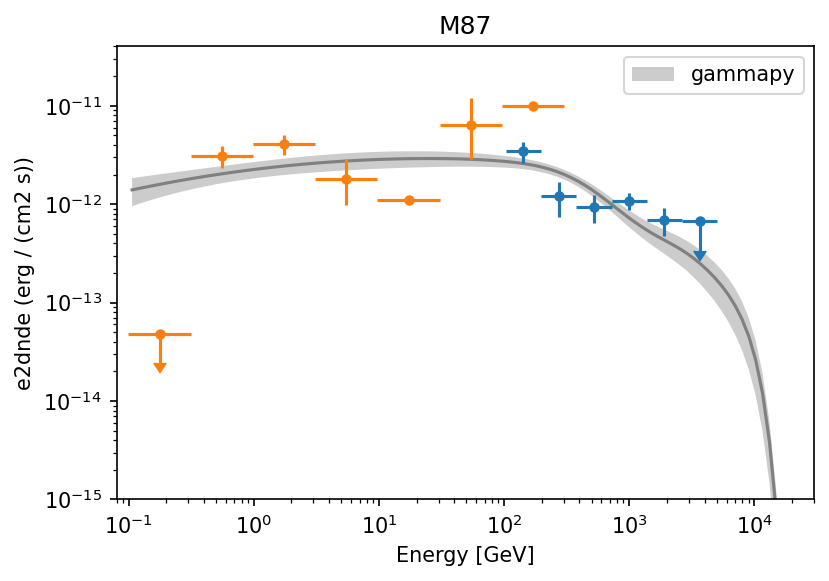

In [49]:
FMSpectrum2.ebin_edges = [0.1*u.GeV,30*u.TeV]
FMSpectrum2.set_target_source(FMSpectrum2.datasets.models[-2].name)
FMSpectrum2.ax.set_xlim([0.08,30000])
FMSpectrum2.ax.set_ylim([1e-15,4e-11])
FMSpectrum2.Fig

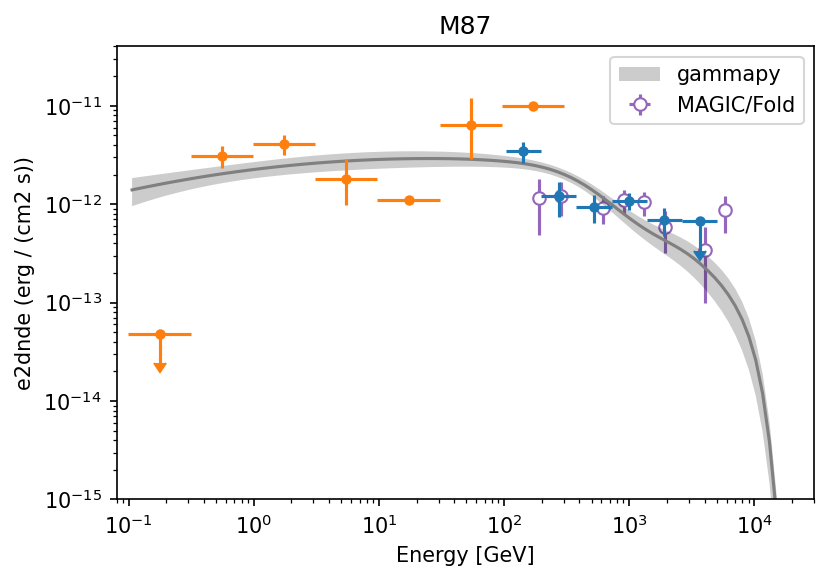

In [50]:
FMSpectrum2.plot_spectrum_fold(f"{magicpath.replace('all','fold')}/Output_fold.root")

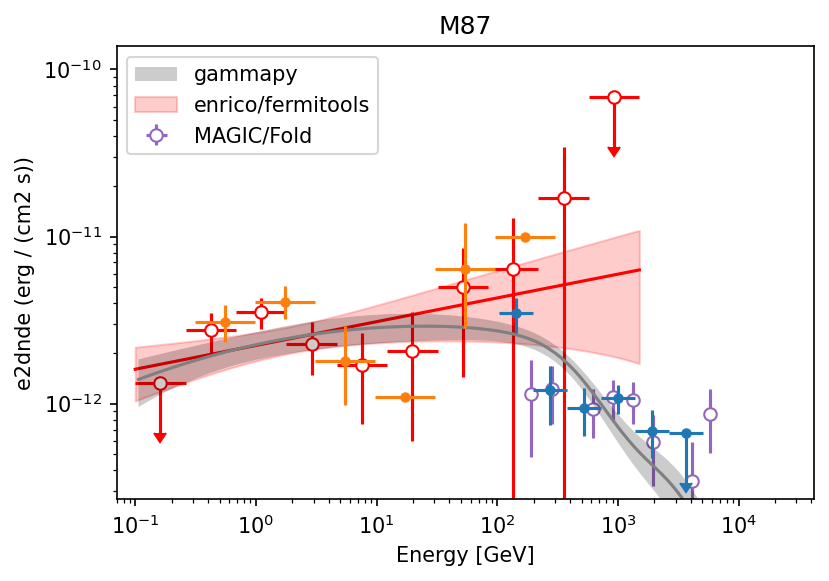

In [51]:
FMSpectrum2.lat_bute = FSpectrum.lat_bute
FMSpectrum2.lat_ebin = FSpectrum.lat_ebin
FMSpectrum2.plot_spectrum_enrico()

In [52]:
FMSpectrum2.ax.set_xlim([0.08,30000])
FMSpectrum2.ax.set_ylim([3e-14,4e-11])

(3e-14, 4e-11)

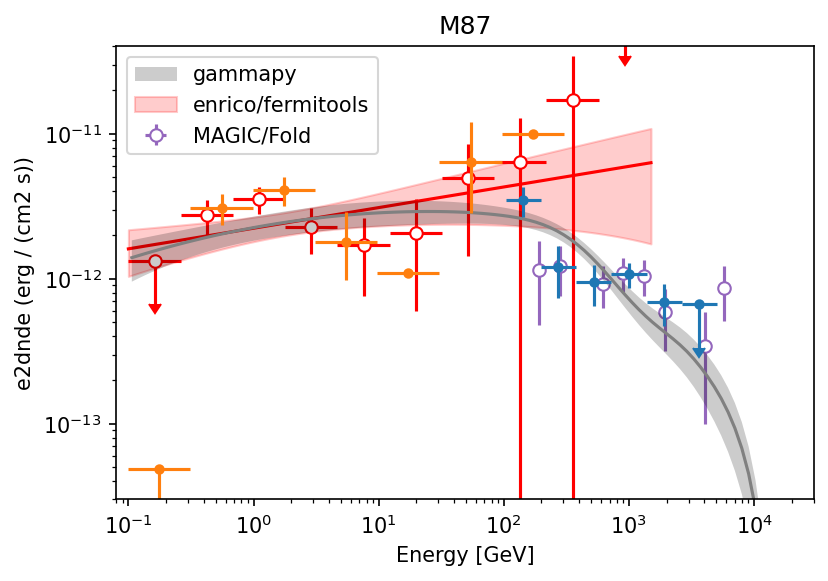

In [53]:
FMSpectrum2.Fig

In [54]:
mod = FMSpectrum2.datasets.models

In [55]:
#for f in mod:
#    if 'M87' not in f.name:
#        f.freeze()

In [56]:
#for f in mod.parameters.free_parameters:
#    print(f)

In [57]:
print(mod[-1])

SkyModel

  Name                      : M87-MAGIC
  Datasets names            : ['MAGIC']
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.78e-08   +/- 3.5e-09 1 / (cm2 s TeV)
    reference             (frozen):     10.000       GeV         
    alpha                         :      1.954   +/-    0.04             
    beta                          :      0.024   +/-    0.02             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.100                   




In [58]:
FMSpectrum2.datasets.models[-2].datasets_names = ['Fermi-LAT_FRONT','MAGIC']

In [59]:
FMSpectrum2.set_target_source(FMSpectrum2.datasets.models[-2].name,FMSpectrum2.datasets[0])
FMSpectrum2.get_spectral_points(np.logspace(-1,4.4,18)*u.GeV)
fptab3 = FMSpectrum2.flux_points

TypeError: unhashable type: 'list'

In [ ]:
fptab3.plot(ax=FMSpectrum2.ax,sed_type='e2dnde')
FMSpectrum2.ax.set_xlim([0.08,30000])
FMSpectrum2.ax.set_ylim([3e-14,4e-11])
FMSpectrum2.Fig

In [ ]:
FMSpectrum2.datasets.models